# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.set_option('expand_frame_repr', True)
import numpy as np
import pubchempy as pcp
from rdkit import Chem
import cirpy #for changing between identifiers
import matplotlib.pyplot as plt
import seaborn as sns

#for web integration
from googlesearch import search
import webbrowser

#for molecular drawings and descriptor calculation
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors as descriptor
from rdkit.Chem import Crippen
from rdkit.Chem import AllChem
#size = (120, 120)  # Smaller figures than the default.

from sklearn import linear_model
import statsmodels.api as sm

#for progress bars
from ipywidgets import widgets, Layout
from IPython.display import display
from ipywidgets import IntProgress 
#Run this part outside of the loop - create progress bar

#max_count = len(cal_df.index.values)
#f = IntProgress(min=0, max=max_count, description='CIDs') # instantiate the bar
#display(f) # display the bar
#count = 0
    
    
#Place this part inside the loop

    #f.value += 1 # signal to increment the progress bar
    #count += 1

Each constant is marked with a symbol denoting how the HLC was obtained
- Some values are calculated (T for thermo calc, Q for QSAR calc)
- Some values are estimates (E)
- Some values are probable incorrect (W)
- As stated above, some data was extrapolated to a different temperature or concentration range (R)

Here I will remove estimated/calculated values from the dataset

# Getting data from the supplement

In [3]:
file = open("../henry_law_dataset/output/HcpSI.f90", "r")
species_f90 = (file.read().split(sep="! species:")) # create list where each element contains one species
species_list = [] 
constant_list = []
cas_list = []

for i in species_f90[1:]: #first line is ! alpha, skip this line with [1:]
    cas_line = i.split(sep='\n')[3] # fourth line contains CAS number
    cas_list.append(cas_line.split(sep='! casrn:   ')[1]) # isolate CAS number and place it in the list
    
    species = i.split(sep='\n')[0] #first line contains species name
    species_list.append(species[1:]) # isolate species name and place it in list
    hcpsi_lines = (i.split(sep='\n')[5:]) #lines past the 6th contain constants
    # each species has a different number of constants
    # loop through them and pull the constant from each line, place them into a list
    const_per_line = [] #list for each species' constants
    for j in range(0, len(hcpsi_lines)):
        if 'HcpSI' in hcpsi_lines[j]: #check if line contains constant
            const_type = hcpsi_lines[j].split(sep='type: ')[1].split(sep=',')[0] # isolate 'type' code
            if (const_type != 'W') and (const_type != 'E') and (const_type != 'T') and (const_type != 'Q') and (const_type != 'V'):
                # remove calculated / incorrect constants
                const_per_line.append(hcpsi_lines[j].split(sep='=  ')[1][0:8]) # add remaining constants to list
        else:
            pass
    
    if 'HcpSI' in i:
        new_value_list = []
        for const in const_per_line:
            # convert constants from strings to floats
            if type(const) == str:
                number = float(const.split(sep='E')[0])
                power = float((const.split(sep='E')[1]))
                new_value = (number*np.power(10, power)) # create float
                log_value = np.log(1/new_value) # inverse of H gives Kh, then take log.
            new_value_list.append(log_value) # put new value into list per species
        constant_list.append(new_value_list) # put new lists into final list of constant lists
    else:
        constant_list.append(np.nan)
print(len(cas_list), len(species_list), len(constant_list), '\n',
     type(cas_list), type(species_list), type(constant_list), '\n',
     type(cas_list[0]), type(species_list[0]), type(constant_list[0])) #checking lists are full and correct type

4632 4632 4632 
 <class 'list'> <class 'list'> <class 'list'> 
 <class 'str'> <class 'str'> <class 'list'>


# Conversion of CAS numbers to SMILES strings

In [12]:
smiles_list = []

max_count = len(cas_list)
f = IntProgress(min=0, max=max_count, description='CAS->SMILES') # instantiate the bar
display(f) # display the bar
count = 0
    
for cas in cas_list:
    smiles_list.append(cirpy.resolve(cas, 'smiles')) #convert CAS to SMILES
    f.value += 1 # signal to increment the progress bar
    count += 1

IntProgress(value=0, description='CAS->SMILES', max=4632)

# Construct table describing set of constants for each species

In [4]:
min_list = []; max_list = []; mean_list = []; median_list = []; num_constants_list = []
for clist in constant_list:
    if (type(clist) == list):
        if (len(clist) != 0):
            #get various stats for each species' constants
            min_list.append(np.min(clist))
            max_list.append(np.max(clist))
            mean_list.append(np.mean(clist))
            median_list.append(np.median(clist))
        else:
            min_list.append(0)
            max_list.append(0)
            mean_list.append(0)
            median_list.append(0)
    else:
        min_list.append(0)
        max_list.append(0)
        mean_list.append(0)
        median_list.append(0)
    if type(clist) == list:
        num_constants_list.append(len(clist))
    else:
        num_constants_list.append(0)
const_list_df = pd.DataFrame(species_list)
const_list_df.rename({0:'Species'}, axis=1, inplace=True)
const_list_df['Num'] = num_constants_list
const_list_df['min'] = min_list    
const_list_df['max'] = max_list    
const_list_df['mean'] = mean_list    
const_list_df['median'] = median_list
const_list_df['max-min'] = np.array(max_list) - np.array(min_list)
const_list_df.set_index('Species', inplace=True)

In [5]:
const_list_df.to_csv('summary_stats_curated_no_vpas.csv') #export summary stats per species for later use

In [6]:
const_list_df = pd.read_csv('summary_stats_curated_no_vpas.csv')

# Visualise data distribution, look at varying constants

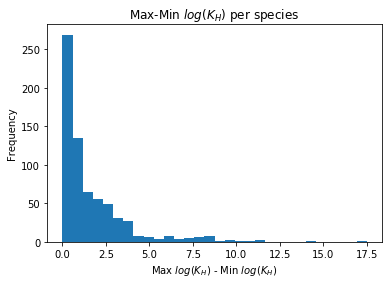

In [7]:
plt.hist(const_list_df[const_list_df['max-min']!=0]['max-min'], bins=30)
plt.title('Max-Min $log(K_H)$ per species')
plt.xlabel('Max $log(K_H)$ - Min $log(K_H)$')
plt.ylabel('Frequency')
hist = plt.gcf()

hist.savefig('range_per_species.png')

In [8]:
display(const_list_df[const_list_df['max-min'] > 15]) #these vary by more than 15 log units
num_species = 0
for num in range(0, 100):
    if len(const_list_df[const_list_df['Num'] == num] != 0):
        print(len(const_list_df[const_list_df['Num'] == num]), "species with %i constant(s)" % num)
    num_species += len(const_list_df[const_list_df['Num'] == num])
if num_species == len(const_list_df):
    print("This accounts for all species")
else:
    print("Not all species accounted for - there are %i species missing from this count" % (len(const_list_df) - num_species))

,Species,Num,min,max,mean,median,max-min
3041,"(2,4-dichlorophenoxy)-ethanoic acid",5,-15.520259,1.966113,-6.359637,-6.877296,17.486372


3018 species with 0 constant(s)
852 species with 1 constant(s)
267 species with 2 constant(s)
113 species with 3 constant(s)
85 species with 4 constant(s)
65 species with 5 constant(s)
38 species with 6 constant(s)
26 species with 7 constant(s)
21 species with 8 constant(s)
24 species with 9 constant(s)
22 species with 10 constant(s)
12 species with 11 constant(s)
10 species with 12 constant(s)
6 species with 13 constant(s)
9 species with 14 constant(s)
4 species with 15 constant(s)
6 species with 16 constant(s)
7 species with 17 constant(s)
3 species with 18 constant(s)
4 species with 19 constant(s)
5 species with 20 constant(s)
3 species with 21 constant(s)
1 species with 22 constant(s)
5 species with 23 constant(s)
5 species with 24 constant(s)
2 species with 25 constant(s)
2 species with 26 constant(s)
1 species with 28 constant(s)
3 species with 29 constant(s)
1 species with 37 constant(s)
1 species with 39 constant(s)
2 species with 40 constant(s)
2 species with 42 constant(s)
1 

Benzene derivatives seem to have lots of constants

In [9]:
const_list_df[const_list_df['Num'] > 30]

,Species,Num,min,max,mean,median,max-min
361,benzene,74,5.599422,6.812445,6.337717,6.319969,1.213023
363,methylbenzene,83,5.878136,8.679712,6.493731,6.502290,2.801576
374,ethylbenzene,39,5.991465,7.323271,6.624986,6.645391,1.331806
961,propanone,40,0.634878,6.969631,1.621596,1.347074,6.334752
964,butanone,37,0.891598,3.611918,1.927867,1.771957,2.720320
2544,dichloromethane,45,5.167289,5.878136,5.586611,5.599422,0.710847
2546,trichloromethane,60,5.339139,6.571283,5.981260,5.991465,1.232144
2547,tetrachloromethane,49,6.812445,9.240800,7.965304,7.986565,2.428354
2550,"1,2-dichloroethane",42,4.422849,7.469874,4.908106,4.797560,3.047026
2552,"1,1,1-trichloroethane",42,6.119298,8.217089,7.395975,7.443935,2.097791


# Marking species with varying HLCs
One-hot encoding to mark these species - not to be used as a feature to train models with.

In [10]:
for vary_by in range(0, 10):
    exec('vary_list_%i = []'% vary_by) # create many empty lists at once
    for i in range(0, len(const_list_df)):
        max_min = const_list_df.iloc[i]['max-min']
        # one hot encoding - for vary_list_x, append 1 if range is larger than x and 0 if not
        if max_min > vary_by:
            exec('vary_list_%i.append(1)'% vary_by)
        else:
            exec('vary_list_%i.append(0)'% vary_by)
    exec('print("vary_list_%i", len(vary_list_%i), "constants total.", vary_list_%i.count(1), "varying constants")'
         %(vary_by, vary_by, vary_by)) #ensure all constants are processed properly

vary_list_0 4632 constants total. 687 varying constants
vary_list_1 4632 constants total. 318 varying constants
vary_list_2 4632 constants total. 200 varying constants
vary_list_3 4632 constants total. 110 varying constants
vary_list_4 4632 constants total. 60 varying constants
vary_list_5 4632 constants total. 44 varying constants
vary_list_6 4632 constants total. 34 varying constants
vary_list_7 4632 constants total. 27 varying constants
vary_list_8 4632 constants total. 17 varying constants
vary_list_9 4632 constants total. 9 varying constants


# Picking constants to use for each species
Henry's Law constants vary by a fair amount - values between species can differ by orders of magnitude. Perhaps its an idea to take the log of the constants as we get them and then work out how to split from there?
> Changed the code in `Getting data from the supplement` to use the log value from the start

Now to figure out which values to use. I think a difference of one log unit is a reasonable threshold to drop, but will check this with Jeremy.

> For now, I will not drop any constants, and will instead use the mean for each species.

I'm going to create several columns in this dataframe - each holding a different choice of constant.

In [11]:
mean_constant_list = [] #take mean for each list of constants
for i in range(0, len(constant_list)):
    if type(constant_list[i]) == list:
        mean_constant_list.append(np.mean(constant_list[i]))
    else:
        mean_constant_list.append(np.nan)
        
first_constant_list = [] #use first constant in each case
for i in range(0, len(constant_list)):
    print(i, constant_list[i])
    if type(constant_list[i]) == list:
        if len(constant_list[i]) > 0:
            first_constant_list.append(constant_list[i][0])
        else:
            first_constant_list.append(np.nan)
    else:
        first_constant_list.append(np.nan)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 [11.330603908176274, 11.250561200502737, 11.250561200502737, 11.250561200502737, 11.250561200502737, 11.250561200502737, 11.250561200502737, 11.250561200502737, 11.330603908176274, 11.250561200502737, 11.250561200502737, 11.250561200502737, 11.330603908176274, 11.250561200502737]
1 [9.210340371976184, 9.210340371976184, 9.115030192171858, 8.947976107508692, 9.115030192171858, 9.028018815182229, 9.115030192171858, 8.947976107508692, 13.815510557964274, 9.028018815182229, 9.282911064811017, 9.282911064811017]
2 [12.859999112936837, 12.859999112936837]
3 [11.761386824268728, 11.774290229104636, 11.748647798491298, 11.774290229104636, 11.774290229104636, 11.774290229104636, 11.774290229104636]
4 [11.748647798491298]
5 [0.9675840262617057, 0.9675840262617057, 1.3862943611198906, -0.6931471805599453, -4.48863636973214, 1.3862943611198906]
6 [-1.916922612182061, -1.916922612182061, -4.04305126783455]
7 [-6.813444599510896, -6.721425700790643, -6.633318433280377, -6.887552571664617, -7.00306

1146 []
1147 []
1148 []
1149 []
1150 []
1151 []
1152 []
1153 []
1154 [-0.40546510810816444]
1155 [-0.587786664902119]
1156 []
1157 []
1158 []
1159 []
1160 []
1161 [2.8647040111475865, 2.8473122684357177, 2.8647040111475865]
1162 []
1163 [3.1941832122778293, 3.270169119255751]
1164 [3.6888794541139363]
1165 [4.074541934925921]
1166 []
1167 [4.268697949366879]
1168 []
1169 []
1170 [3.2968373663379125, 3.036554268074246, 3.036554268074246]
1171 [3.540459448995663, 3.7297014486341915, 3.6119184129778077]
1172 [3.9633162998156966]
1173 []
1174 [4.605170185988092, 4.961845129926823]
1175 []
1176 []
1177 nan
1178 []
1179 []
1180 [3.473768074496991, 3.473768074496991]
1181 [3.6119184129778077]
1182 [4.721704002244043, 3.6119184129778077]
1183 []
1184 []
1185 [3.9633162998156966, 3.6119184129778077, 3.6119184129778077]
1186 [4.268697949366879, 4.017383521085972]
1187 []
1188 [3.912023005428146]
1189 [4.615220521841593, 4.3428059215206005]
1190 [4.509860006183766]
1191 []
1192 []
1193 []
1194 []

2093 [-6.13122648948314]
2094 []
2095 []
2096 []
2097 []
2098 []
2099 []
2100 []
2101 nan
2102 []
2103 []
2104 []
2105 []
2106 []
2107 [-7.696212639346407]
2108 []
2109 []
2110 []
2111 [-14.603967918328545]
2112 []
2113 []
2114 []
2115 []
2116 []
2117 []
2118 []
2119 []
2120 []
2121 [-16.523560759066484]
2122 []
2123 [-7.901007051992421]
2124 []
2125 []
2126 []
2127 []
2128 []
2129 []
2130 []
2131 []
2132 []
2133 []
2134 []
2135 []
2136 []
2137 []
2138 []
2139 []
2140 []
2141 [-4.59511985013459]
2142 []
2143 []
2144 []
2145 []
2146 []
2147 []
2148 []
2149 [-4.941642422609305]
2150 []
2151 []
2152 []
2153 []
2154 []
2155 []
2156 []
2157 []
2158 []
2159 []
2160 [-2.0281482472922856]
2161 []
2162 []
2163 []
2164 []
2165 []
2166 []
2167 []
2168 []
2169 [-8.961879012677683]
2170 []
2171 []
2172 []
2173 []
2174 []
2175 []
2176 []
2177 []
2178 []
2179 []
2180 []
2181 []
2182 []
2183 []
2184 []
2185 []
2186 []
2187 []
2188 []
2189 []
2190 [-1.1631508098056809]
2191 []
2192 []
2193 []
2194 []
2

3282 []
3283 []
3284 []
3285 []
3286 []
3287 []
3288 []
3289 []
3290 []
3291 []
3292 []
3293 []
3294 []
3295 []
3296 []
3297 []
3298 [0.5276327420823718]
3299 []
3300 []
3301 []
3302 []
3303 []
3304 []
3305 []
3306 []
3307 []
3308 []
3309 []
3310 []
3311 []
3312 []
3313 []
3314 []
3315 []
3316 []
3317 []
3318 []
3319 []
3320 []
3321 []
3322 []
3323 []
3324 []
3325 []
3326 []
3327 []
3328 []
3329 []
3330 []
3331 []
3332 []
3333 []
3334 []
3335 []
3336 []
3337 []
3338 []
3339 []
3340 []
3341 []
3342 []
3343 []
3344 []
3345 []
3346 []
3347 []
3348 []
3349 []
3350 []
3351 []
3352 []
3353 []
3354 []
3355 []
3356 []
3357 []
3358 []
3359 []
3360 []
3361 [1.7719568419318752]
3362 []
3363 []
3364 [1.3093333199837622]
3365 []
3366 []
3367 []
3368 []
3369 []
3370 []
3371 []
3372 []
3373 []
3374 []
3375 []
3376 []
3377 [0.6931471805599453]
3378 []
3379 []
3380 []
3381 []
3382 []
3383 []
3384 []
3385 []
3386 []
3387 []
3388 []
3389 []
3390 []
3391 []
3392 [1.9661128563728327]
3393 []
3394 []
3395 [

4272 []
4273 []
4274 []
4275 []
4276 []
4277 []
4278 []
4279 []
4280 []
4281 []
4282 []
4283 []
4284 []
4285 [-10.87804719253426]
4286 []
4287 []
4288 []
4289 []
4290 []
4291 []
4292 []
4293 [-19.67344371244773]
4294 [-4.700480365792417]
4295 []
4296 []
4297 []
4298 []
4299 [0.8915981192837835]
4300 []
4301 [0.07257069283483517]
4302 []
4303 []
4304 []
4305 []
4306 []
4307 [-0.3364722366212129, -0.3364722366212129, -0.3364722366212129, -0.3364722366212129, -0.2623642644674911, -0.3364722366212129, 1.8971199848858813, 2.0402208285265546, 0.08338160893905121]
4308 [-3.2188758248682006, -3.0910424533583156, -2.9444389791664407, -0.916290731874155, -0.0953101798043249]
4309 []
4310 []
4311 []
4312 []
4313 []
4314 []
4315 []
4316 []
4317 []
4318 []
4319 [-10.46310334047155]
4320 []
4321 []
4322 []
4323 [-12.206072645530174]
4324 []
4325 []
4326 [-24.249626361562573]
4327 [-0.2623642644674911]
4328 [-21.639556568820566]
4329 [-23.85876005287556]
4330 []
4331 []
4332 []
4333 []
4334 []
4335 [

# Construct dataframe of SMILES, names and constants for all species

In [13]:
smiles_list = pd.read_csv('../smiles_constants.csv').iloc[:, 2] #already constructed smiles list from CAS numbers
smiles_list.head()

0         O=O
1     O=[O]=O
2      [H][H]
3         [H]
4    [2H][2H]
Name: 1, dtype: object

In [14]:
smiles_constant_species = pd.concat([pd.Series(species_list), #creating dataframe to hold all info found so far
                                     pd.Series(smiles_list),
                                     pd.Series(mean_constant_list), #kept first Kh and mean in each case
                                     pd.Series(first_constant_list), #will train on both sets and see which is better
                                    pd.Series(vary_list_1), #one-hot encoded variation in constants
                                    pd.Series(vary_list_2), #to be used for highlighting after training
                                    pd.Series(vary_list_3), # /not/ to be used as a feature
                                    pd.Series(vary_list_4), #perhaps could be used to weight certain species?
                                    pd.Series(vary_list_5),
                                    pd.Series(vary_list_6),
                                    pd.Series(vary_list_7),
                                    pd.Series(vary_list_8),
                                    pd.Series(vary_list_9)],
                                    axis=1)
smiles_constant_species.to_csv('smiles_constants_kh_noVPAS.csv') #export so all the work isn't lost
smiles_constant_species.set_index(0, inplace=True)
smiles_constant_species.rename({'1':'SMILES', 1:'Kh_mean', 2:'Kh_first', 3:'Varying_1',
                               4:'Varying_2', 5:'Varying_3', 6:'Varying_4', 7:'Varying_5',
                               8:'Varying_6', 9:'Varying_7', 10:'Varying_8', 11:'Varying_9'}, axis=1, inplace=True)

In [15]:
smiles_constant_species.head()

,SMILES,Kh_mean,Kh_first,Varying_1,Varying_2,Varying_3,Varying_4,Varying_5,Varying_6,Varying_7,Varying_8,Varying_9
0,,,,,,,,,,,,
oxygen,O=O,11.267713,11.330604,0,0,0,0,0,0,0,0,0
ozone,O=[O]=O,9.508258,9.210340,1,1,1,1,0,0,0,0,0
hydrogen atom,[H][H],12.859999,12.859999,0,0,0,0,0,0,0,0,0
hydrogen,[H],11.768784,11.761387,0,0,0,0,0,0,0,0,0
deuterium,[2H][2H],11.748648,11.748648,0,0,0,0,0,0,0,0,0


# Dropping species with no experimental constants

In [18]:
print('Species to drop: ', len(const_list_df[const_list_df['Num'] == 0]))
no_constants = const_list_df[const_list_df['Num'] == 0]
to_drop = list(no_constants.index.values)
constants = const_list_df[const_list_df['Num'] != 0]
to_keep = list(constants.index.values)

Species to drop:  3018


In [23]:
filtered_smiles_constant_species = smiles_constant_species.iloc[to_keep]
filtered_smiles_constant_species.rename({1:'SMILES', 2:'Constant', 3:'Varying'}, axis=1, inplace=True)
filtered_smiles_constant_species.head()

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,SMILES,Kh_mean,Kh_first,Varying_1,Varying_2,Varying_3,Varying_4,Varying_5,Varying_6,Varying_7,Varying_8,Varying_9
0,,,,,,,,,,,,
oxygen,O=O,11.267713,11.330604,0,0,0,0,0,0,0,0,0
ozone,O=[O]=O,9.508258,9.210340,1,1,1,1,0,0,0,0,0
hydrogen atom,[H][H],12.859999,12.859999,0,0,0,0,0,0,0,0,0
hydrogen,[H],11.768784,11.761387,0,0,0,0,0,0,0,0,0
deuterium,[2H][2H],11.748648,11.748648,0,0,0,0,0,0,0,0,0


2100 species no longer have constants - this is from the entire set, not just organics.

Now to get the list of smiles strings for this experimental set

# Organic/inorganic split

In [25]:
carbons_list = [] ; no_carbons_list = []
for i in range(0, len(filtered_smiles_constant_species)):
    smiles = filtered_smiles_constant_species.SMILES.iloc[i]
    try:
        mol = Chem.MolFromSmiles(smiles) # create rdkit mol object
        smarts = Chem.MolToSmarts(mol) # use mol object to create SMARTS
    except:
        smarts = 'x' #mark failed species in the list
    name = filtered_smiles_constant_species.index[i]
    if type(smarts) == str:
        if '#6' in smarts:
            carbons_list.append(i) # RDKit SMARTS strings work by atomic number (hence carbon = #6)
        else:
            no_carbons_list.append(i) # append non-carbon-containing species to a seperate list

In [26]:
organics = filtered_smiles_constant_species.iloc[carbons_list] # new df containing carbon compounds only

# Removing metal-containing species

In [27]:
drop_list = []
# removing metals using list of common metals.
# aniline compound at beginnning contains (corrupted?) SMILES string full of tungsten.
metals_removal_list = ["4,4',4''-methanetriyltris(N,N-diethylaniline)", 'Hg', 'Se', 'As', 'Zn', 'Si', 'Na', 'Al', 'Pb', 'Sn']
for i in range(0, len(organics)):
    for metal in metals_removal_list:
        if metal in organics.SMILES[i]:
            drop_list.append(organics.index[i])
            #create drop list in loop, then remove all metal-containing species at once

organics.drop(labels=drop_list, inplace=True, axis=0)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
organics.head()

,SMILES,Kh_mean,Kh_first,Varying_1,Varying_2,Varying_3,Varying_4,Varying_5,Varying_6,Varying_7,Varying_8,Varying_9
0,,,,,,,,,,,,
methane,C,11.208749,11.176453,0,0,0,0,0,0,0,0,0
ethane,CC,10.895310,10.871072,0,0,0,0,0,0,0,0,0
propane,CCC,11.151950,11.107460,0,0,0,0,0,0,0,0,0
butane,CCCC,11.380748,11.330604,0,0,0,0,0,0,0,0,0
2-methylpropane,CC(C)C,11.304097,11.607236,1,1,0,0,0,0,0,0,0


# Export organics as csv

In [29]:
organics.to_csv('filtered_organics_kh_noVPAS.csv')

# RUN UP TO HERE SO FAR

# Get list of SMILES strings to pass into DRAGON

In [216]:
file = open('smi_files/filtered_organics.smi', mode='w')
for i in range(0, len(organics)):
    string = organics.iloc[i].SMILES #get each smiles string
    file.write(string) # write it to the file
    file.write('\n') #new line so DRAGON recieves each species seperately

# Get list of InChIs to grab solubility data from PubChem

In [42]:
df = pd.read_csv('filtered_organics.csv')
smiles_list = df.SMILES

In [45]:
max_count = len(smiles_list)
f = IntProgress(min=0, max=max_count, description='SMILES->InChI') # instantiate the bar
display(f) # display the bar
count = 0
    
inchi_list = []
for smiles in smiles_list:
    inchi = cirpy.resolve(smiles, 'stdinchi')
    f.value += 1 # signal to increment the progress bar
    count += 1
    inchi_list.append(inchi)
    
#convert to pd series
#export to df
#pass df to pubchem
pd.Series(inchi_list).to_csv('inchi_list_filtered_organics.csv')

IntProgress(value=0, description='SMILES->InChI', max=2196)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  app.launch_new_instance()


# To-do
- (done)Change CAS to SMILES 
- (done)Create df for smiles, species and constant
- (done)filter dataframe with the `to_keep` or `to_drop` index lists
- (done-ish)pick which constants to use for each species
- (done)Get list of SMILES strings to pass into DRAGON
- (done)pass new set of species through DRAGON
- (done)ML from there